In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax

from flax import nnx

In [2]:
X = np.linspace(0, 1, 100)[:, None]
Y = 0.8 * X**2 + 0.1 + np.random.normal(0, 0.1, size=X.shape)


def dataset(batch_size):
  while True:
    idx = np.random.choice(len(X), size=batch_size)
    yield X[idx], Y[idx]

In [3]:
class Linear(nnx.Module):
  def __init__(self, din: int, dout: int, *, rngs: nnx.Rngs):
    self.w = nnx.Param(jax.random.uniform(rngs.params(), (din, dout)))
    self.b = nnx.Param(jnp.zeros((dout,)))

  def __call__(self, x):
    return x @ self.w.value + self.b.value


class Count(nnx.Variable):
  pass


class MLP(nnx.Module):
  def __init__(self, din, dhidden, dout, *, rngs: nnx.Rngs):
    self.count = Count(jnp.array(0))
    self.linear1 = Linear(din, dhidden, rngs=rngs)
    self.linear2 = Linear(dhidden, dout, rngs=rngs)

  def __call__(self, x):
    self.count.value += 1
    x = self.linear1(x)
    x = jax.nn.relu(x)
    x = self.linear2(x)
    return x


model = MLP(din=1, dhidden=32, dout=1, rngs=nnx.Rngs(0))
tx = optax.sgd(1e-3)
optimizer = nnx.Optimizer(model, tx)

In [4]:
@nnx.jit
def train_step(model: MLP, optimizer: nnx.Optimizer, batch):
  x, y = batch

  def loss_fn(model: MLP):
    y_pred = model(x)
    return jnp.mean((y - y_pred) ** 2)

  grads: nnx.State = nnx.grad(loss_fn)(model)
  optimizer.update(grads)


@nnx.jit
def test_step(model: MLP, batch):
  x, y = batch
  y_pred = model(x)
  loss = jnp.mean((y - y_pred) ** 2)
  return {'loss': loss}

step: 0, loss: 17.989042282104492
step: 1000, loss: 0.050821974873542786
step: 2000, loss: 0.019961347803473473
step: 3000, loss: 0.013110318221151829
step: 4000, loss: 0.011291266418993473
step: 5000, loss: 0.010756460949778557
step: 6000, loss: 0.010544943623244762
step: 7000, loss: 0.010435454547405243
step: 8000, loss: 0.010351412929594517
step: 9000, loss: 0.010276012122631073
times called: 10010


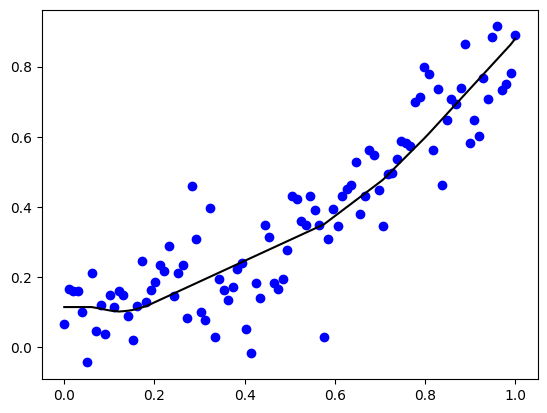

In [5]:
total_steps = 10_000
for step, batch in enumerate(dataset(32)):
  train_step(model, optimizer, batch)

  if step % 1000 == 0:
    logs = test_step(model, (X, Y))
    print(f"step: {step}, loss: {logs['loss']}")

  if step >= total_steps - 1:
    break

print('times called:', model.count.value)

y_pred = model(X)

plt.scatter(X, Y, color='blue')
plt.plot(X, y_pred, color='black')
plt.show()